# Getting started

The goal of `simple` is to have a tiny [probablistic programming](https://en.wikipedia.org/wiki/Probabilistic_programming) language compatible with some of the most common sampling libraries.
That way, it is easy to write a model (including all priors) for `emcee`, and then run it with `nautilus`, for example.

In this tutorial, we will do a short demo by sampling a 3D normal distribution.


In [1]:
import simple

print(simple.__version__)

0.1.dev37+g211d3a7.d20250618


## Model Definition

The two key components we need to specify in a Bayesian model are the prior distribution and the likelihood function.
Pretty much all sampling libraries require these two components, either separately for nested sampling, or combined in a posterior for MCMC.

In `simple`, the prior is specified as a dictionary of `Distribution` objects.
Most common distributions are already implemented in scipy, so the recommended approach, inspired by [nautilus](https://nautilus-sampler.readthedocs.io/en/latest/guides/priors.html), is to simply wrap scipy distributions whenever possible.

In [2]:
from scipy.stats import norm, uniform

from simple.distributions import ScipyDistribution

parameters = {
    "x1": ScipyDistribution(uniform, -5, 10),
    "x2": ScipyDistribution(uniform, 0, 10),
    "x3": ScipyDistribution(norm(0, 10)),
}
print("Priors:")
print(parameters)

Priors:
{'x1': ScipyDistribution(uniform(-5, 10)), 'x2': ScipyDistribution(uniform(0, 10)), 'x3': ScipyDistribution(norm(0, 10))}


Next, we need a log-likelihood function that takes a dictionary of parameters and computes the likelihood.
Here we don't have a dataset: we will just specify a distribution of three parameters directly.

In [3]:
from scipy.stats import multivariate_normal


def log_likelihood(params):
    """Log-likelihood function for a 3D normal distribution."""
    p = [params["x1"], params["x2"], params["x3"]]
    mean = [0.0, 3.0, 2.0]
    cov = [[1, 0.5, 0], [0.5, 1, 0], [0, 0, 1.0]]
    return multivariate_normal.logpdf(p, mean=mean, cov=cov)

It is now time to create our `simple.Model` object.
The model needs to know what our priors and likelihood are.
It will then wrap them to provide:

- `log_prior(parameters)`: the prior distribution given a dictionary or an array of parameters
- `log_prob(parameters)`: the posterior distribution given a dictionary or an array of parameters
- `log_likelihood(parameters)`: a wrapper around our log-likelihood above to make it work with arrays and dictionaries
- `prior_transform(parameters)`: a prior transform from a unit hypercube to our parameter space

In [4]:
from simple.model import Model

model = Model(parameters, log_likelihood)

print(model)
test_point = [0, 1, 0]
print("Log-Prior", model.log_prior(test_point))
print("Log-Prior out of bounds", model.log_prior([-10, 3, 0]))
print("Log-likelihood", model.log_likelihood(test_point))
print("Log-posterior", model.log_prob(test_point))

Model(parameters={'x1': ScipyDistribution(uniform(-5, 10)), 'x2': ScipyDistribution(uniform(0, 10)), 'x3': ScipyDistribution(norm(0, 10))}, log_likelihood=<bound method Model.log_likelihood of ...>)
Log-Prior -7.826693812186811
Log-Prior out of bounds -inf
Log-likelihood -7.279641230054793
Log-posterior -15.106335042241604


## Prior Checks

A good thing to do before fitting any model is to check the prior.
To sample directly from the prior, we can either pass a uniform distribution through the `prior_transform` function or sample the `log_prior()` function of our model with `emcee`.

Here, we will test both approaches.
In practice, it's probably a good idea to test your prior transform if you plan on using nested sampling and your log-prior if you plan on using MCMC.

### Via prior transform

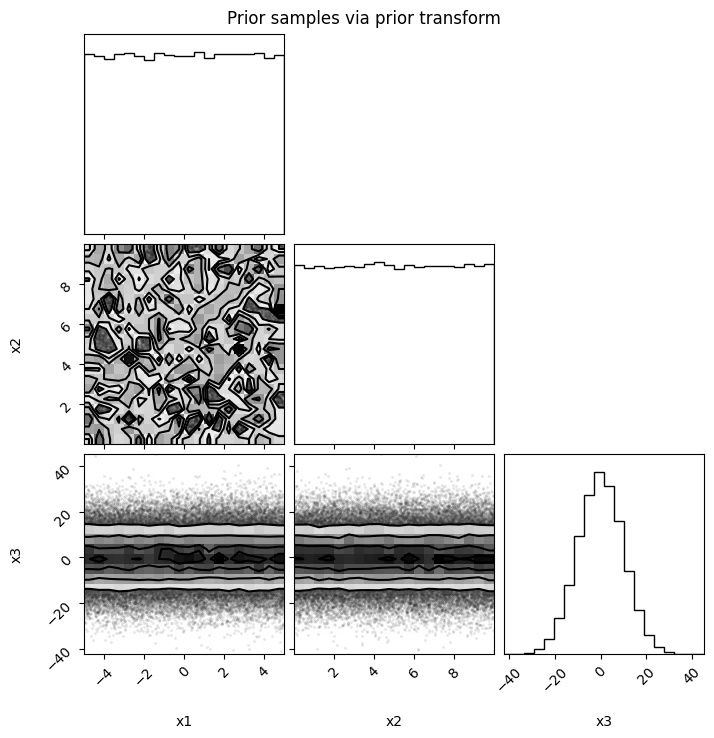

In [5]:
import corner
import matplotlib.pyplot as plt
import numpy as np

rng = np.random.default_rng()
u = np.random.uniform(0, 1, size=(3, 100_000))
prior_samples = model.prior_transform(u)

fig = corner.corner(prior_samples.T, labels=model.keys())
fig.suptitle("Prior samples via prior transform")
plt.show()

### Via emcee

In [6]:
import emcee

sampler = emcee.EnsembleSampler(
    nwalkers=100,
    ndim=3,
    log_prob_fn=model.log_prior,
)

In [7]:
p0 = np.array(test_point) + 1e-4 * rng.standard_normal(size=(100, 3))
sampler.run_mcmc(p0, 1000, progress=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.46it/s]


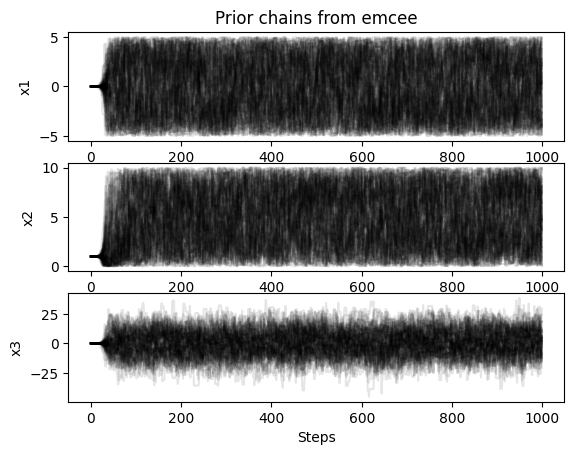

In [8]:
chains = sampler.get_chain()

fig, axs = plt.subplots(3, 1)
for i in range(3):
    axs[i].plot(chains[:, :, i], "k-", alpha=0.1)
    axs[i].set_ylabel(model.keys()[i])
axs[-1].set_xlabel("Steps")
axs[0].set_title("Prior chains from emcee")
plt.show()

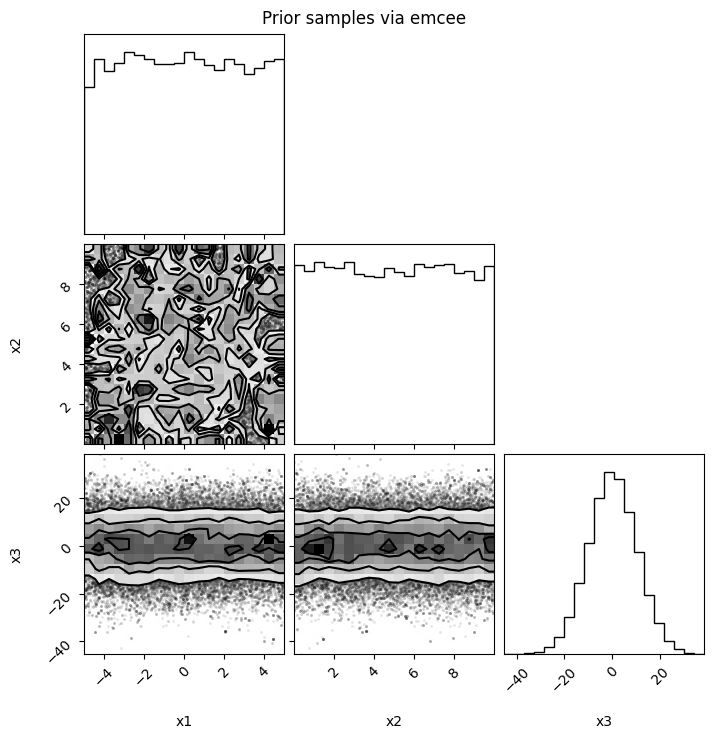

In [9]:
flat_chains = sampler.get_chain(discard=200, flat=True)
fig = corner.corner(flat_chains, labels=model.keys())
fig.suptitle("Prior samples via emcee")
plt.show()

## Sampling with `emcee`

We can now sample the posterior with emcee. We can basically copy the previous subsection, but replace `log_prior` with `log_prob` in our sampler definition.

In [10]:
import emcee

sampler = emcee.EnsembleSampler(
    nwalkers=100,
    ndim=3,
    log_prob_fn=model.log_prob,
)

In [11]:
p0 = np.array(test_point) + 1e-4 * rng.standard_normal(size=(100, 3))
sampler.run_mcmc(p0, 1000, progress=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:40<00:00, 24.80it/s]


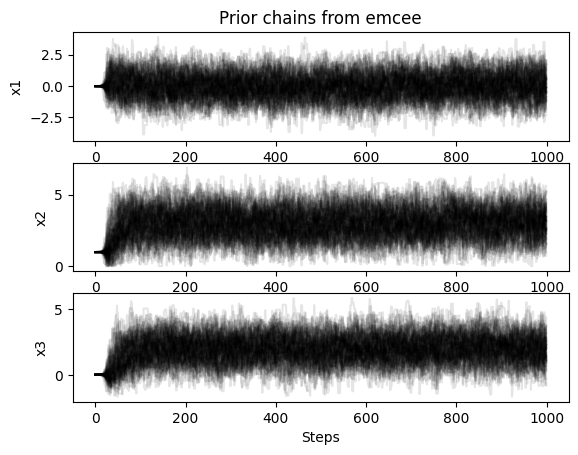

In [12]:
chains = sampler.get_chain()

fig, axs = plt.subplots(3, 1)
for i in range(3):
    axs[i].plot(chains[:, :, i], "k-", alpha=0.1)
    axs[i].set_ylabel(model.keys()[i])
axs[-1].set_xlabel("Steps")
axs[0].set_title("Prior chains from emcee")
plt.show()

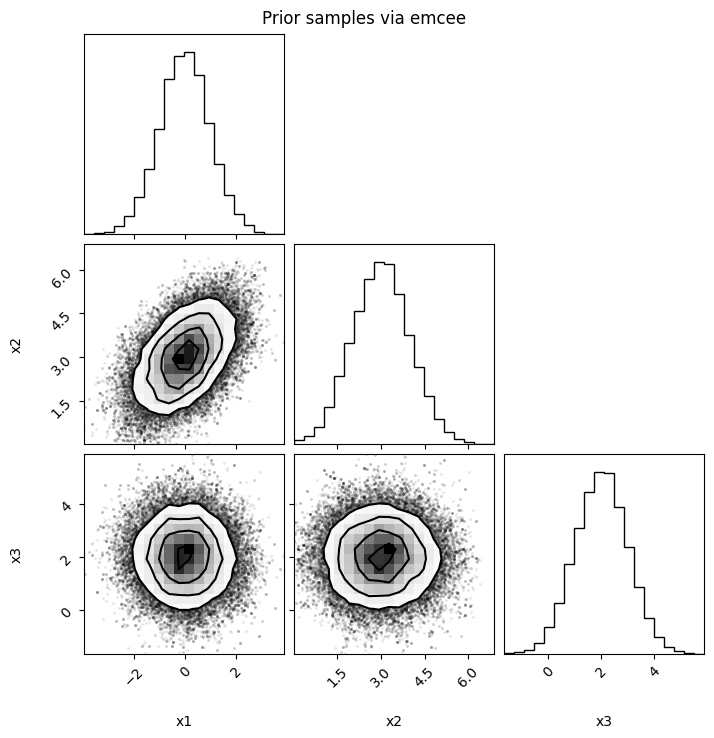

In [13]:
flat_chains = sampler.get_chain(discard=200, flat=True)
fig = corner.corner(flat_chains, labels=model.keys())
fig.suptitle("Prior samples via emcee")
plt.show()

## Sampling with `ultranest`

Next, let us try and sample the model with Ultranest.

In [14]:
import ultranest

sampler = ultranest.ReactiveNestedSampler(
    model.keys(), model.log_likelihood, model.prior_transform
)

result = sampler.run(show_status=False)

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3  
[ultranest] Likelihood function evaluations: 6182
[ultranest]   logZ = -7.939 +- 0.06076
[ultranest] Effective samples strategy satisfied (ESS = 1862.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.06, need <0.5)
[ultranest]   logZ error budget: single: 0.10 bs:0.06 tail:0.01 total:0.06 required:<0.50
[ultranest] done iterating.


In [15]:
sampler.print_results()


logZ = -7.944 +- 0.123
  single instance: logZ = -7.944 +- 0.098
  bootstrapped   : logZ = -7.939 +- 0.123
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    x1                  : -3.90 │ ▁ ▁▁▁▁▁▁▂▂▃▄▅▅▇▇▇▇▇▇▆▄▄▂▃▂▁▁▁▁▁▁▁   ▁ │4.62      0.02 +- 1.00
    x2                  : 0.00  │▁▁▁▁▁▁▂▂▃▃▃▄▅▆▆▇▇▆▆▆▅▅▄▄▃▂▂▁▁▁▁▁▁▁ ▁▁▁ │6.93      3.00 +- 0.97
    x3                  : -2.18 │ ▁▁▁▁▁▁▁▁▁▁▁▂▃▄▅▅▆▇▇▇▇▇▆▅▃▄▃▂▁▁▁▁▁▁▁▁▁ │5.79      1.98 +- 0.98



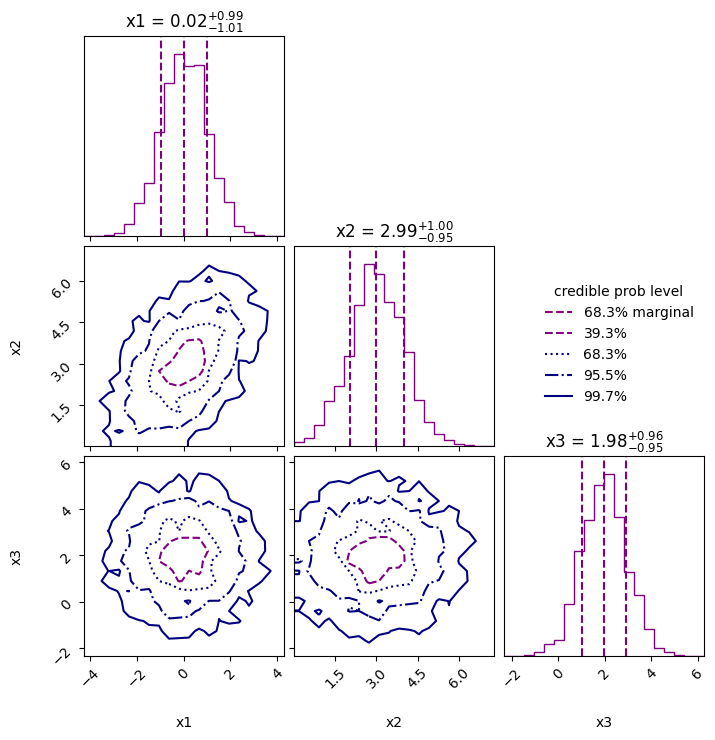

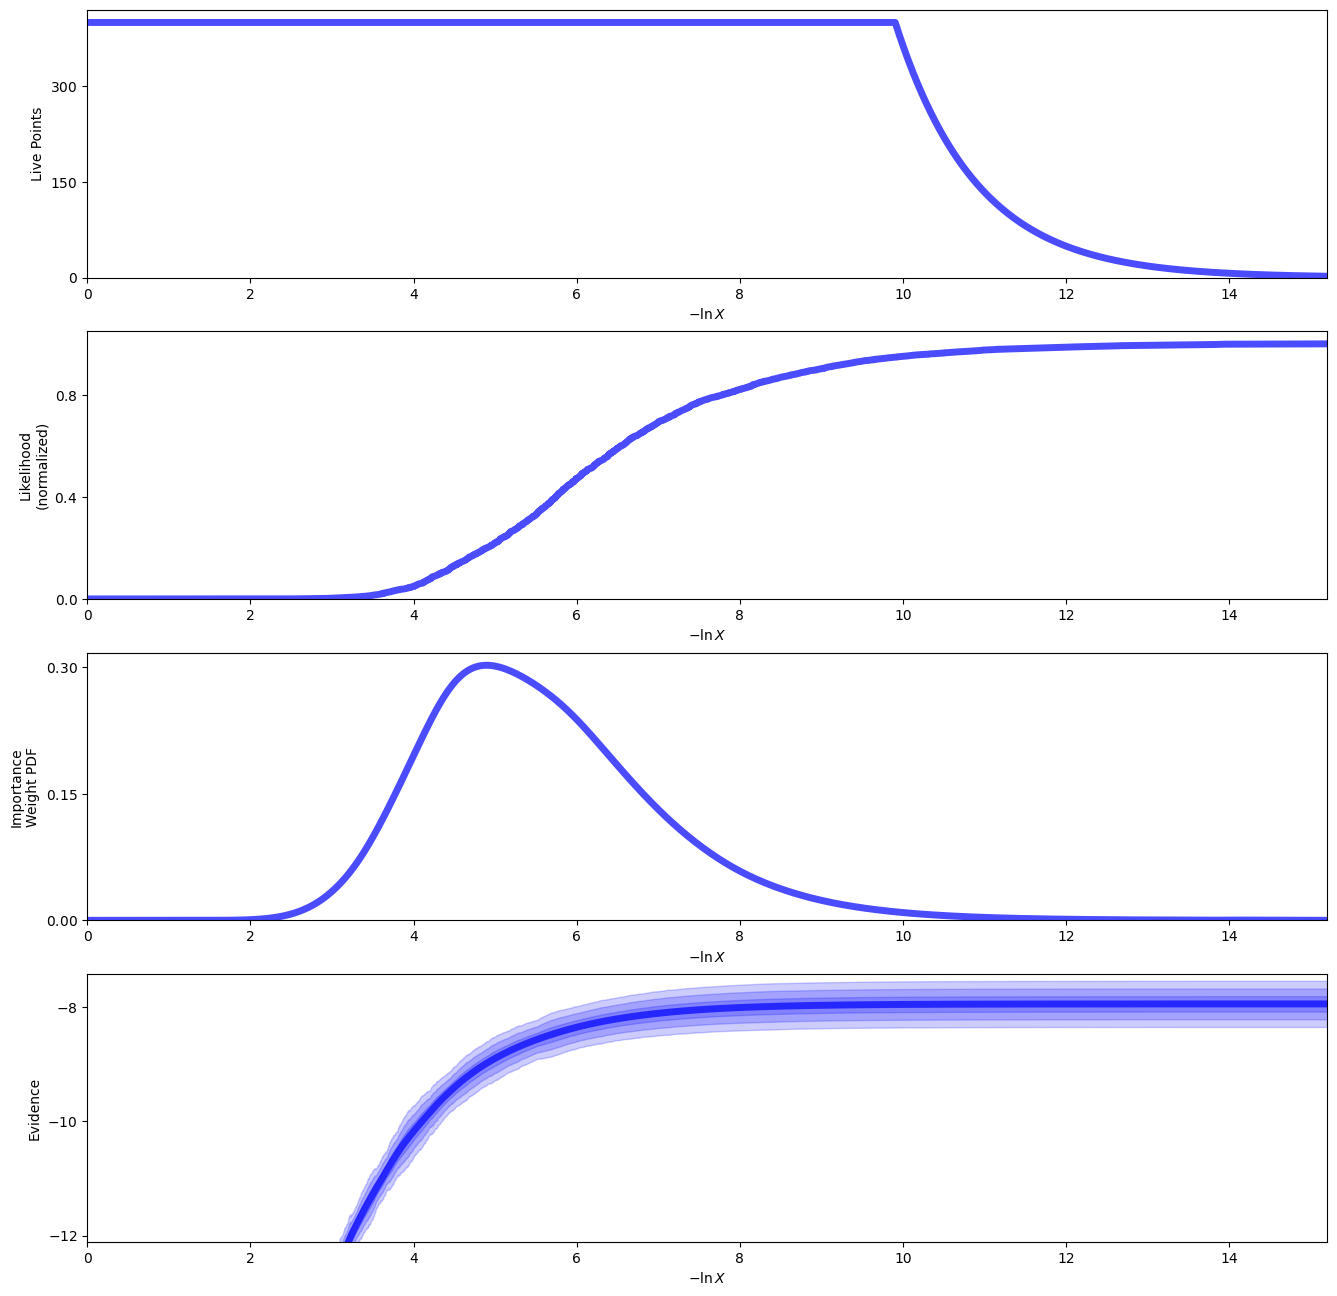

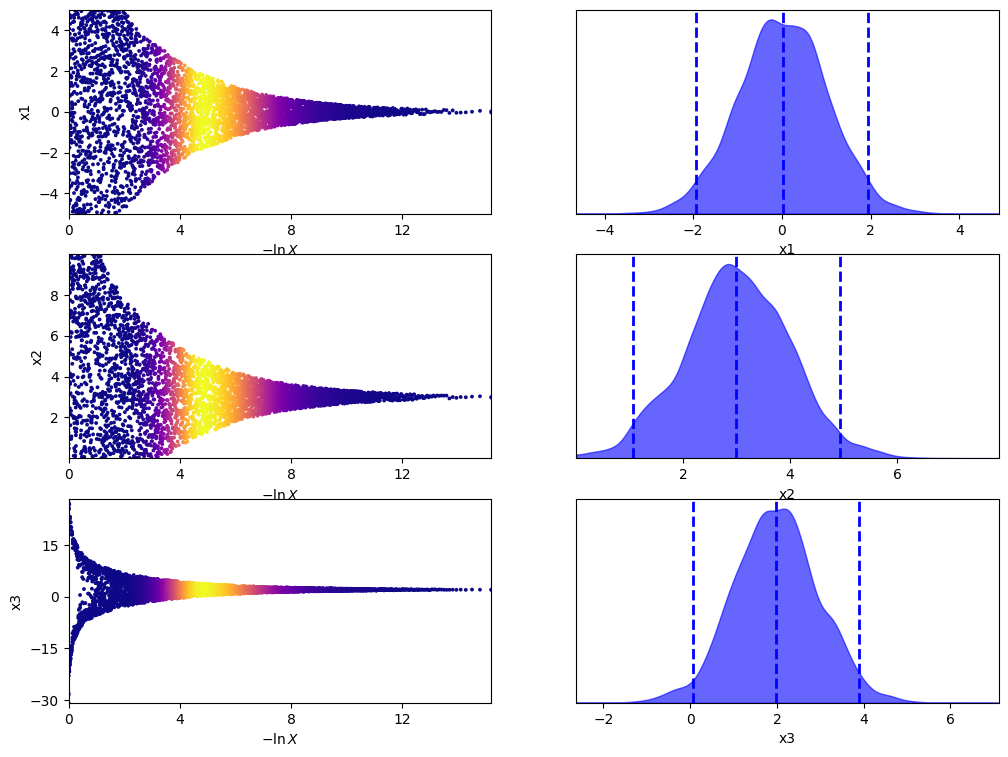

In [16]:
sampler.plot_corner()
plt.show()
sampler.plot_run()
plt.show()
sampler.plot_trace()
plt.show()

## Sampling with `nautilus`

In [17]:
from nautilus import Sampler

sampler = Sampler(model.nautilus_prior(), model.log_likelihood, n_live=1000)
sampler.run(verbose=True)

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 14     | 1        | 4        | 17700    | N/A    | 10090 | -7.86    


np.True_

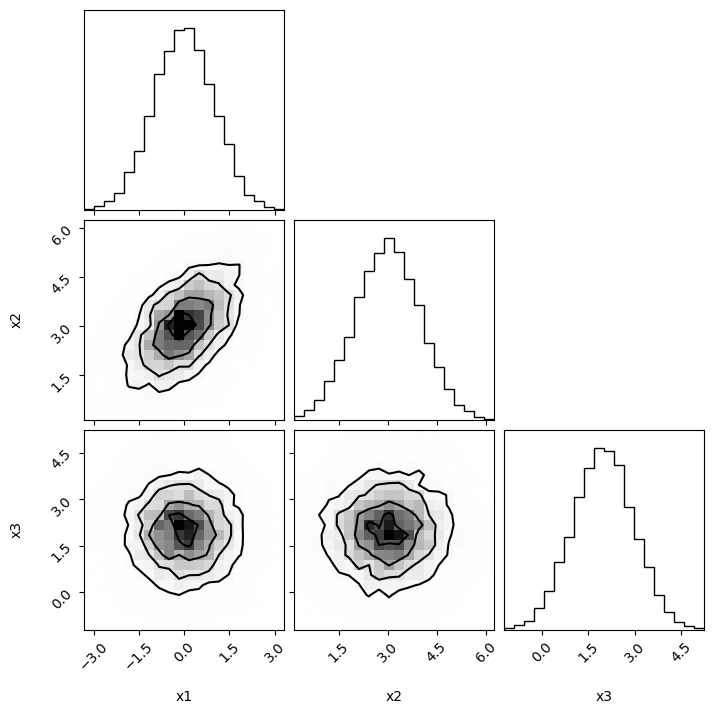

In [18]:
points, log_w, log_l = sampler.posterior()
corner.corner(
    points,
    weights=np.exp(log_w),
    labels=model.keys(),
    plot_datapoints=False,
    range=np.repeat(0.999, len(model.parameters)),
)
plt.show()

## Comparison

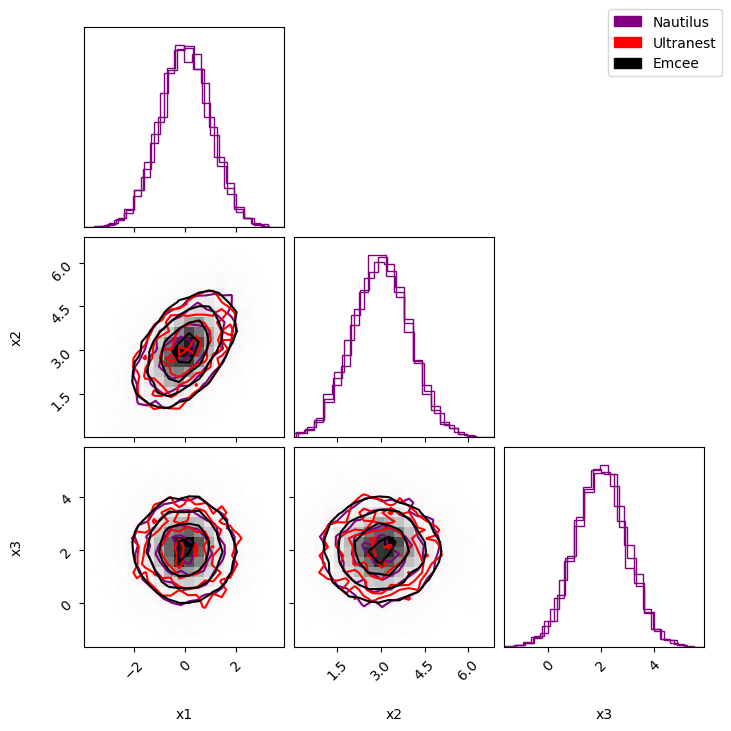

In [19]:
from matplotlib import patches

hist_kwargs = dict(density=True)

fig = corner.corner(
    points,
    weights=np.exp(log_w),
    labels=model.keys(),
    color="purple",
    hist_kwargs=hist_kwargs,
    plot_datapoints=False,
    range=np.repeat(0.999, len(model.parameters)),
)
data = np.array(result["weighted_samples"]["points"])
weights = np.array(result["weighted_samples"]["weights"])
corner.corner(
    data,
    weights=weights,
    color="red",
    hist_kwargs=hist_kwargs,
    plot_datapoints=False,
    range=np.repeat(0.999, len(model.parameters)),
    fig=fig,
)
corner.corner(
    flat_chains,
    weights=np.ones(flat_chains.shape[0]),
    color="k",
    hist_kwargs=hist_kwargs,
    plot_datapoints=False,
    fig=fig,
)


nautilus_patch = patches.Patch(color="purple", label="Nautilus")
ultranest_patch = patches.Patch(color="red", label="Ultranest")
emcee_patch = patches.Patch(color="k", label="Emcee")

fig.legend(
    handles=[nautilus_patch, ultranest_patch, emcee_patch],
    loc="upper right",  # You can also use 'upper left', 'lower right', etc.
    bbox_to_anchor=(0.98, 0.98),
)

plt.show()